In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
  print('Working on CUDA...')
else:
  device = 'cpu'
  print('Working on CPU...')

Working on CPU...


In [ ]:
batch_size = 32
num_workers = 0
valid_size = 0.2

data_transform = transforms.Compose([#transforms.RandomResizedCrop(224),
                                     transforms.RandomAffine(30),
                                     transforms.RandomHorizontalFlip(0.5),
                                     transforms.RandomRotation(30),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10('data', train=True, download=True, transform=data_transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=data_transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(valid_size * num_train)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

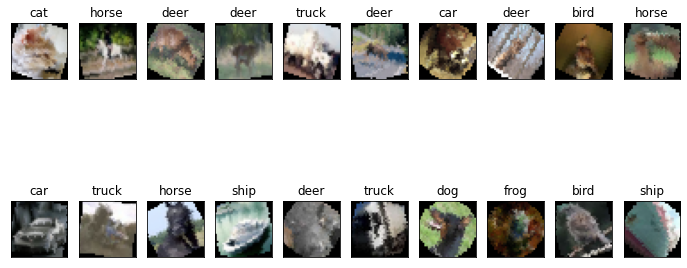

In [ ]:
# Display images

def show(img):
  img = img / 2 + 0.5
  plt.imshow(np.transpose(img, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(12, 6))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  show(images[idx])
  ax.set_title(classes[labels[idx]])

In [ ]:
# The LeNet architecture model

class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    # Input shape --> : 32 * 32 * 3
    self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
    # Shape --> 16 * 16 * 16 - MaxPool reduces x-y dimensions by a factor of 2 here. And no. of channels increases from 3 to 16
    self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1) # Shape --> 8 * 8 * 32
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(32 * 8 * 8, 512)
    self.fc2 = nn.Linear(512, 10)

  def forward(self, x):  # Input shape: 32 * 32 * 3
    x = self.pool(F.relu(self.conv1(x)))  # 16 * 16 * 16
    x = self.pool(F.relu(self.conv2(x)))  # 8 * 8 * 32
    x = x.view(-1, 32 * 8 * 8)
    x = F.relu(self.fc1(x))
    x = F.softmax(self.fc2(x), dim=1)

    return x

model = LeNet()
print(model)

if device == 'cuda':
  model.cuda()

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 20
train_losses = []
valid_losses = []
valid_accuracies = []

valid_loss_min = np.Inf

for e in range(epochs):
  train_loss = 0.0
  valid_loss = 0.0

  for images, labels in train_loader:
    if device == 'cuda':
      images, labels = images.cuda(), labels.cuda()

    optimizer.zero_grad()
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  model.eval()
  accuracy = 0
  for images, labels in validation_loader:
    if device == 'cuda':
      images, labels = images.cuda(), labels.cuda()

    logps = model(images)
    loss = criterion(logps, labels)
    ps = torch.exp(logps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    valid_loss += loss.item()

  train_loss = train_loss / len(train_loader)
  valid_loss = valid_loss / len(validation_loader)
  accuracy = accuracy / len(validation_loader)

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  valid_accuracies.append(accuracy)

  print('Epoch {}'.format(e+1),
        'Training Loss: {:.3f}'.format(train_loss),
        'Validation Loss: {:.3f}'.format(valid_loss),
        'Validation accuracy: {:.3f}'.format(accuracy))
  
  if valid_loss <= valid_loss_min:
    print('Validation Loss decreased: {:.6f} --> {:.6f}. Saving Model...'.format(
          valid_loss_min, valid_loss))
    torch.save(model.state_dict(), 'model_cifar10.pt')
    valid_loss_min = valid_loss

Epoch 1 Training Loss: 2.096 Validation Loss: 2.023 Validation accuracy: 0.433
Validation Loss decreased: inf --> 2.022836. Saving Model...
Epoch 2 Training Loss: 2.013 Validation Loss: 1.991 Validation accuracy: 0.464
Validation Loss decreased: 2.022836 --> 1.991375. Saving Model...
Epoch 3 Training Loss: 1.983 Validation Loss: 1.971 Validation accuracy: 0.485
Validation Loss decreased: 1.991375 --> 1.971301. Saving Model...
Epoch 4 Training Loss: 1.962 Validation Loss: 1.960 Validation accuracy: 0.497
Validation Loss decreased: 1.971301 --> 1.960037. Saving Model...
Epoch 5 Training Loss: 1.942 Validation Loss: 1.947 Validation accuracy: 0.510
Validation Loss decreased: 1.960037 --> 1.946678. Saving Model...
Epoch 6 Training Loss: 1.930 Validation Loss: 1.929 Validation accuracy: 0.528
Validation Loss decreased: 1.946678 --> 1.929007. Saving Model...
Epoch 7 Training Loss: 1.923 Validation Loss: 1.908 Validation accuracy: 0.551
Validation Loss decreased: 1.929007 --> 1.907578. Saving

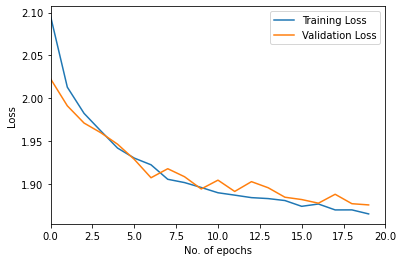

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')

plt.xlim([0, 20])

plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
model.load_state_dict(torch.load('model_cifar10.pt'))

<All keys matched successfully>

In [ ]:
test_loss = 0.0
test_accuracy = 0.0

model.eval()
for images, labels in test_loader:
  if device == 'cuda':
    images, labels = images.cuda(), labels.cuda()

  logps = model.forward(images)
  loss = criterion(logps, labels)
  test_loss += loss.item()

  ps = torch.exp(logps)
  top_p, top_class = ps.topk(1, dim=1)
  equals = top_class == labels.view(*top_class.shape)
  test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

test_accuracy = test_accuracy / len(test_loader)

print('Test accuracy: {}'.format(test_accuracy))
print('\n')
test_loss = test_loss / len(test_loader)
print('Test Loss: {}'.format(test_loss))

Test accuracy: 0.577276357827476


Test Loss: 1.8804979488110771


**CONCLUSION:**


*   Model is marginally overfitting since the validation loss is slightly greater than the training loss and is also not steady. Test accuracy of 0.577 can be increased by increasing the number of layers to learn complex intricate patterns in the images.
*   Nevertheless, the model is doing a moderately good job even though only two convolutional layers were being used.

